###Importing Proper Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


%matplotlib inline

###Loading CSV Files

In [3]:
au_train = pd.read_csv('au_train.csv', na_values=" ?")
au_test = pd.read_csv('au_test.csv', na_values=" ?")

In [4]:
au_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
au_test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.


###Initial Data Overview

By running the info function on the dataframe, we quickly answer many important questions.
- We are given the total number of records for each columns.
- Because everything is non-null (or at least before we passed the na_values through read.csv) all attributes for each individual has an assigned value.
- The dtype of each column is important to know as well as one thinks ahead to data cleaning and modeling.

In [6]:
au_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  class           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [7]:
au_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workclass       15318 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education       16281 non-null  object
 4   education-num   16281 non-null  int64 
 5   marital-status  16281 non-null  object
 6   occupation      15315 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital-gain    16281 non-null  int64 
 11  capital-loss    16281 non-null  int64 
 12  hours-per-week  16281 non-null  int64 
 13  native-country  16007 non-null  object
 14  class           16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


In [8]:
au_train.isnull().values.any()

True

In [9]:
au_test.isnull().values.any()

True

###Data Cleaning

Viewing all columns with non-integer dtypes provides more information.
- 'fnlwgt' is a column with no inherent description and contains 21648 unique values. Therefore, I will drop this column since I am uncertain of its value to the model. In the future if more information is given, and it is proven to be a significant number, I would probably bin them into categories.
- Additionally, I will be dropping "education" since it is redundant with "education-num".
- All string values have fronted white spaces, which could cause confusion. Therefore, all white spaces are stripped.
- Next, although there are techinically no null values, it seems those that should be be null were replaced with " ?". This will be corrected by replacing "?" with nan values in the loading cell.
- When looking at the test set, there are also "."s after each value in *class*. Those will also be scrubbed.
- When viewing the unique values, with respective to the object columns there is a difference between the test and training set in only one instance: the test set is missing "Holland-Netherlands". Since I am creating dummy values already for the sets (and since the dictionaries created from the unique values isn't long and there's only one difference), I will add a column to the test set with 0s under a new "Holand-Netherlands" columns to create a joint number of features. Not doing so would result in uneven training and testing features.

In [10]:
au_train = au_train.drop(columns=['fnlwgt', 'education'])
au_test = au_test.drop(columns=['fnlwgt', 'education'])

In [11]:
object_columns = ['workclass','marital-status','occupation',
                  'relationship','race','sex','native-country', 'class']

num_columns = ['age','education-num','hours-per-week', 'capital-gain','capital-loss']

print("Object Columns: Training Set")
for x in au_train[object_columns]:
  j = au_train[x].nunique()
  print(x, "has ", j, "unique values.")

print("\nInteger Columns: Training Set")
for x in au_train[num_columns]:
  j = au_train[x].nunique()
  print(x, "has ", j, "unique values.")

print("\nObject Columns: Test Set")
for x in au_test[object_columns]:
  j = au_test[x].nunique()
  print(x, "has ", j, "unique values.")

print("\nInteger Columns: Test Set")
for x in au_test[num_columns]:
  j = au_test[x].nunique()
  print(x, "has ", j, "unique values.")

Object Columns: Training Set
workclass has  8 unique values.
marital-status has  7 unique values.
occupation has  14 unique values.
relationship has  6 unique values.
race has  5 unique values.
sex has  2 unique values.
native-country has  41 unique values.
class has  2 unique values.

Integer Columns: Training Set
age has  73 unique values.
education-num has  16 unique values.
hours-per-week has  94 unique values.
capital-gain has  119 unique values.
capital-loss has  92 unique values.

Object Columns: Test Set
workclass has  8 unique values.
marital-status has  7 unique values.
occupation has  14 unique values.
relationship has  6 unique values.
race has  5 unique values.
sex has  2 unique values.
native-country has  40 unique values.
class has  2 unique values.

Integer Columns: Test Set
age has  73 unique values.
education-num has  16 unique values.
hours-per-week has  89 unique values.
capital-gain has  113 unique values.
capital-loss has  82 unique values.


In [12]:
def see_unique(x):
  print(x.workclass.unique())
  print(x['marital-status'].unique())
  print(x.occupation.unique())
  print(x.relationship.unique())
  print(x.race.unique())
  print(x.sex.unique())
  print(x['native-country'].unique())
  print(x['class'].unique())

see_unique(au_train)

[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 nan ' Self-emp-inc' ' Without-pay' ' Never-worked']
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' nan
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
[' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']
[' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other']
[' Male' ' Female']
[' United-States' ' Cuba' ' Jamaica' ' India' nan ' Mexico' ' South'
 ' Puerto-Rico' ' Honduras' ' England' ' Canada' ' Germany' ' Iran'
 ' Philippines' ' Italy' ' Poland' ' Columbia' ' Cambodia' ' Thailand'
 ' Ecuador' ' Laos' ' Taiwan' ' Haiti' ' Portugal' ' Dominican-Republic'
 ' El-Salvador' ' France' ' Guatemala'

In [13]:
see_unique(au_test)

[' Private' ' Local-gov' nan ' Self-emp-not-inc' ' Federal-gov'
 ' State-gov' ' Self-emp-inc' ' Without-pay' ' Never-worked']
[' Never-married' ' Married-civ-spouse' ' Widowed' ' Divorced'
 ' Separated' ' Married-spouse-absent' ' Married-AF-spouse']
[' Machine-op-inspct' ' Farming-fishing' ' Protective-serv' nan
 ' Other-service' ' Prof-specialty' ' Craft-repair' ' Adm-clerical'
 ' Exec-managerial' ' Tech-support' ' Sales' ' Priv-house-serv'
 ' Transport-moving' ' Handlers-cleaners' ' Armed-Forces']
[' Own-child' ' Husband' ' Not-in-family' ' Unmarried' ' Wife'
 ' Other-relative']
[' Black' ' White' ' Asian-Pac-Islander' ' Other' ' Amer-Indian-Eskimo']
[' Male' ' Female']
[' United-States' nan ' Peru' ' Guatemala' ' Mexico' ' Dominican-Republic'
 ' Ireland' ' Germany' ' Philippines' ' Thailand' ' Haiti' ' El-Salvador'
 ' Puerto-Rico' ' Vietnam' ' South' ' Columbia' ' Japan' ' India'
 ' Cambodia' ' Poland' ' Laos' ' England' ' Cuba' ' Taiwan' ' Italy'
 ' Canada' ' Portugal' ' China' ' N

In [14]:
au_train = au_train.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
au_test = au_test.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
au_test = au_test.apply(lambda x: x.str.strip('.') if x.dtype == 'object' else x)
print(see_unique(au_train))
print(see_unique(au_test))

['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' nan
 'Self-emp-inc' 'Without-pay' 'Never-worked']
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' nan
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']
['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
['Male' 'Female']
['United-States' 'Cuba' 'Jamaica' 'India' nan 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'England' 'Canada' 'Germany' 'Iran'
 'Philippines' 'Italy' 'Poland' 'Columbia' 'Cambodia' 'Thailand' 'Ecuador'
 'Laos' 'Taiwan' 'Haiti' 'Portugal' 'Dominican-Republic' 'El-Salvador'
 'France' 'Guatemala' 'China' 'Japan' 'Yugoslavia' 'Peru'
 'Outlying-US(Guam-USVI-etc)' 'Sc

In [15]:
print(au_train.isnull().sum())
print("{:.2%} of workclass is null.".format(au_train['workclass'].isnull().sum()/au_train['workclass'].count()))
print("{:.2%} of occupation is null.".format(au_train['occupation'].isnull().sum()/au_train['occupation'].count()))
print("{:.2%} of native-country is null.".format(au_train['native-country'].isnull().sum()/au_train['native-country'].count()))

age                  0
workclass         1836
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
class                0
dtype: int64
5.98% of workclass is null.
6.00% of occupation is null.
1.82% of native-country is null.


In [16]:
print(au_test.isnull().sum())
print("{:.2%} of workclass is null.".format(au_test['workclass'].isnull().sum()/au_test['workclass'].count()))
print("{:.2%} of occupation is null.".format(au_test['occupation'].isnull().sum()/au_test['occupation'].count()))
print("{:.2%} of native-country is null.".format(au_test['native-country'].isnull().sum()/au_test['native-country'].count()))

age                 0
workclass         963
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
class               0
dtype: int64
6.29% of workclass is null.
6.31% of occupation is null.
1.71% of native-country is null.


In [17]:
au_train.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456
std,13.640433,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8cf69298d0>,
      dtype=object)

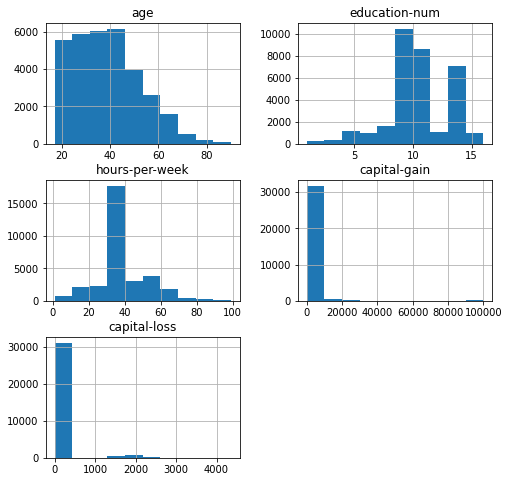

In [18]:
au_train[num_columns].hist(figsize=(8,8))

In [19]:
au_train = pd.get_dummies(au_train, columns=['workclass','marital-status','occupation',
                  'relationship','race','sex','native-country','class'], 
                prefix=['workclass','marital-status','occupation',
                  'relationship','race','sex','native-country','class'])

au_test = pd.get_dummies(au_test, columns=['workclass','marital-status','occupation',
                  'relationship','race','sex','native-country','class'], 
                prefix=['workclass','marital-status','occupation',
                  'relationship','race','sex','native-country','class'])

In [20]:
au_test['native-country_Holand-Netherlands'] = 0

In [21]:
au_test = au_test.drop(['class_<=50K'], axis=1)
au_train = au_train.drop(['class_<=50K'], axis=1)

###Classification Algorithms


Since the question being targeted is categorical, I will deploy three of the most common classification algorithms:
- Logistic Regression
- Decision Tree Classifier
- Naive Bayes
- K-Nearest Neighbors

In [22]:
X_train = au_train.drop("class_>50K", axis=1)
y_train = au_train['class_>50K']
X_test = au_test.drop('class_>50K', axis=1)
y_test = au_test['class_>50K']

####Data Pipelines

In [23]:
def scaled_accuracy(model, X_train, X_test, y_train, y_test):
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)

  model.fit(X_train, y_train)

  X_test = scaler.transform(X_test)

  predictions = model.predict(X_test)

  acc = accuracy_score(y_test, predictions)
  
  print("\n(Scaled) ", model," Testing Accuracy: {:.2%}".format(acc))
  cf_matrix = confusion_matrix(list(y_test), predictions)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [24]:
def non_scaled_accuracy(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)

  acc = accuracy_score(y_test, predictions)
  
  print("\n(Non-Scaled) ", model," Testing Accuracy: {:.2%}".format(acc))
  cf_matrix = confusion_matrix(list(y_test), predictions)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

####Logistic Regression


 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)  Testing Accuracy: 85.06%


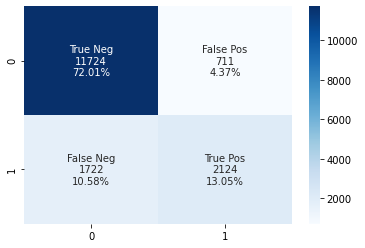

In [25]:
LR_non_scaled = non_scaled_accuracy(LogisticRegression(max_iter=2500), X_train, X_test, y_train, y_test)
LR_non_scaled


 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)  Testing Accuracy: 84.55%


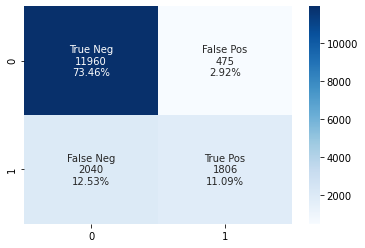

In [38]:
LR_scaled = scaled_accuracy(LogisticRegression(), X_train, X_test, y_train, y_test)
LR_scaled

####Decision Tree Classifier


 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')  Testing Accuracy: 80.38%


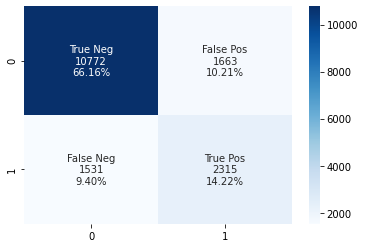

In [26]:
DT_non_scaled = non_scaled_accuracy(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)
DT_non_scaled


 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')  Testing Accuracy: 80.97%


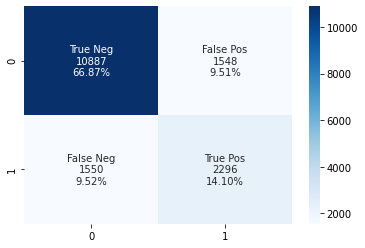

In [39]:
DT_scaled = scaled_accuracy(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)
DT_scaled

####Naive Bayes


 GaussianNB(priors=None, var_smoothing=1e-09)  Testing Accuracy: 80.42%


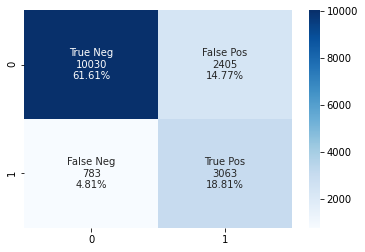

In [27]:
NB_non_scaled = non_scaled_accuracy(GaussianNB(), X_train, X_test, y_train, y_test)
NB_non_scaled


 GaussianNB(priors=None, var_smoothing=1e-09)  Testing Accuracy: 75.47%


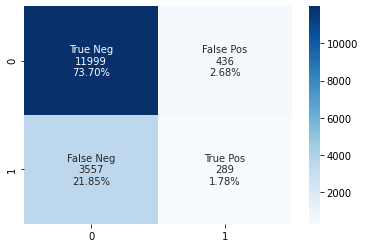

In [40]:
NB_scaled = scaled_accuracy(GaussianNB(), X_train, X_test, y_train, y_test)
NB_scaled

####K-Nearest Neighbors


 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')  Testing Accuracy: 85.07%


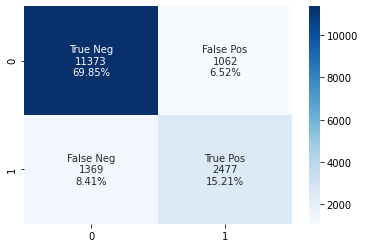

In [28]:
KN_non_scaled = non_scaled_accuracy(KNeighborsClassifier(), X_train, X_test, y_train, y_test)
KN_non_scaled


 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')  Testing Accuracy: 76.49%


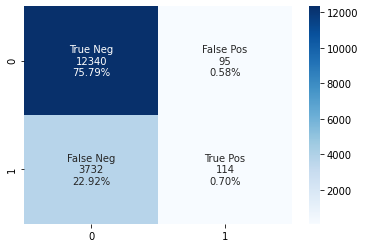

In [41]:
KN_scaled = scaled_accuracy(KNeighborsClassifier(), X_train, X_test, y_train, y_test)
KN_scaled

###AUROC

In [42]:
def non_scaled_roc_auc(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)

  acc = accuracy_score(y_test, predictions)

  model_roc_auc = roc_auc_score(y_test, predictions)

  false_pos, true_pos, threshold = roc_curve(y_test, model.predict_proba(X_test)[:,1])

  plt.figure()
  plt.plot(false_pos, true_pos, label= "Model 1 (area = %0.2f)" %model_roc_auc)
  plt.plot([0,1], [0,1], 'r--')
  plt.title("Receiver Operating Characteristics")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend(loc="lower right")
  plt.show()

In [43]:
def scaled_roc_auc(model, X_train, X_test, y_train, y_test):
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  model.fit(X_train, y_train)
  X_test = scaler.transform(X_test)
  predictions = model.predict(X_test)
  acc = accuracy_score(y_test, predictions)

  model_roc_auc = roc_auc_score(y_test, predictions)

  false_pos, true_pos, threshold = roc_curve(y_test, model.predict_proba(X_test)[:,1])

  plt.figure()
  plt.plot(false_pos, true_pos, label= "Model 1 (area = %0.2f)" %model_roc_auc)
  plt.plot([0,1], [0,1], 'r--')
  plt.title("Receiver Operating Characteristics")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend(loc="lower right")
  plt.show()

####Logistic Regression

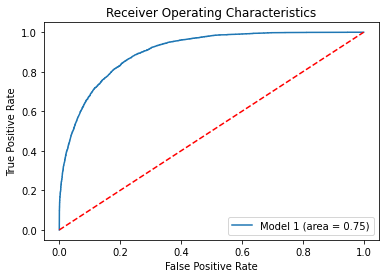

In [44]:
non_scaled_roc_auc(LogisticRegression(max_iter=2500), X_train, X_test, y_train, y_test)

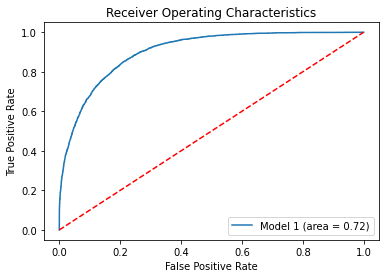

In [45]:
scaled_roc_auc(LogisticRegression(max_iter=2500), X_train, X_test, y_train, y_test)

####Decision Tree Classifier

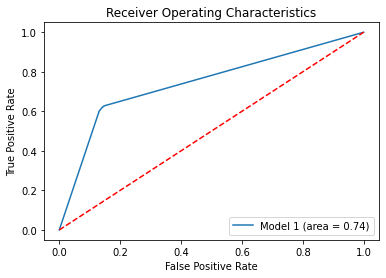

In [35]:
non_scaled_roc_auc(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

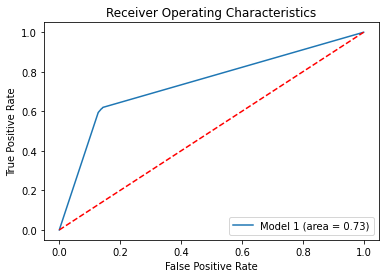

In [46]:
scaled_roc_auc(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

####Naive Bayes

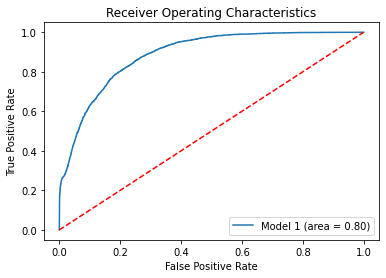

In [36]:
non_scaled_roc_auc(GaussianNB(), X_train, X_test, y_train, y_test)

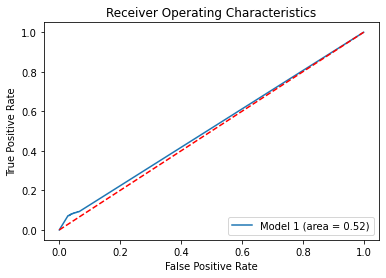

In [47]:
scaled_roc_auc(GaussianNB(), X_train, X_test, y_train, y_test)

####K-Nearest Neighbors

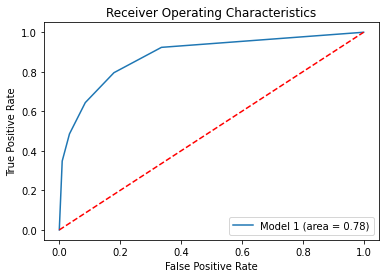

In [37]:
non_scaled_roc_auc(KNeighborsClassifier(), X_train, X_test, y_train, y_test)

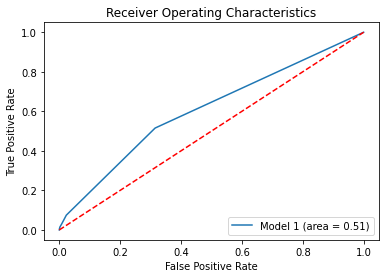

In [48]:
scaled_roc_auc(KNeighborsClassifier(), X_train, X_test, y_train, y_test)